In [ ]:
import yfinance as yf
import numpy as np
import requests
import nltk
import pickle
import pandas as pd
import math
from datetime import datetime
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from nltk.sentiment import SentimentIntensityAnalyzer
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# ---------------------- STOCK PRICE PREDICTION ---------------------- #

# Function to fetch stock data
def get_historical(quote, period="90d"):
    data = yf.download(quote, period=period)
    if data.empty:
        raise ValueError("No stock data available. Check the symbol or API limits.")
    return data

# ARIMA Model
def arima_model(train, test):
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=(6,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(test[t])
    return predictions

# ARIMA Prediction
def ARIMA_ALGO(df):
    df['Price'] = df['Close']
    quantity = df['Price'].values
    size = int(len(quantity) * 0.80)
    train, test = quantity[:size], quantity[size:]
    predictions = arima_model(train, test)
    error_arima = math.sqrt(mean_squared_error(test, predictions))
    return predictions, error_arima

# LSTM Prediction
def LSTM_ALGO(df):
    model = load_model("general_lstm_model.h5")
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

    dataset_train = df.iloc[:int(0.8 * len(df)), :]
    dataset_test = df.iloc[int(0.8 * len(df)):, :]
    real_stock_price = dataset_test['Close'].values.reshape(-1, 1)

    dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis=0)
    testing_set = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values.reshape(-1, 1)
    testing_set = scaler.transform(testing_set)

    X_test = []
    for i in range(7, len(testing_set)):
        X_test.append(testing_set[i-7:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
    error_lstm = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    return predicted_stock_price, error_lstm


In [ ]:
# ---------------------- SENTIMENT ANALYSIS ---------------------- #

# Fetch news articles using NewsAPI
def fetch_news(api_key, query="AAPL", page_size=10):
    url = f"https://newsapi.org/v2/everything?q={query}&sortBy=publishedAt&pageSize={page_size}&apiKey={api_key}"
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching news:", response.json())
        return []

    articles = response.json().get("articles", [])
    return [{"title": article["title"], "description": article["description"]} for article in articles]

# Analyze sentiment of news articles
def analyze_sentiment(news_data):
    sentiments = []
    for article in news_data:
        text = article["title"] + " " + (article["description"] if article["description"] else "")
        sentiment_score = sia.polarity_scores(text)["compound"]  # VADER compound score
        sentiments.append(sentiment_score)

    avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
    return avg_sentiment  # Final sentiment index

In [ ]:
# ---------------------- FINAL PREDICTION FUNCTION ---------------------- #

def predict_stock(stock_symbol, news_api_key):
    # Fetch stock data
    stock_data = get_historical(stock_symbol)

    # Ensure 'Close' column exists
    if "Close" not in stock_data.columns:
        raise ValueError("Error: 'Close' column not found in stock data.")

    # Run ARIMA & LSTM
    arima_pred, arima_error = ARIMA_ALGO(stock_data)
    lstm_pred, lstm_error = LSTM_ALGO(stock_data)

    # Fetch latest stock price
    actual_data = yf.Ticker(stock_symbol).history(period="2d")
    actual_price = actual_data["Close"].iloc[-1] if "Close" in actual_data.columns else None

    # Fetch news & analyze sentiment
    news_data = fetch_news(news_api_key, stock_symbol)
    sentiment_index = analyze_sentiment(news_data)

    # Sentiment-based adjustment (±2%)
    sentiment_adjustment = 1 + (sentiment_index * 0.02)

    # Apply sentiment impact to both models
    final_arima_pred = arima_pred[-1] * sentiment_adjustment
    final_lstm_pred = lstm_pred[-1][0] * sentiment_adjustment

    # Display Results
    print(f"\n📌 Stock Symbol: {stock_symbol}")
    print(f"📈 Actual Stock Price: {actual_price}")
    print(f"📊 ARIMA Prediction (Raw): {arima_pred[-1]}")
    print(f"🤖 LSTM Prediction (Raw): {lstm_pred[-1][0]}")
    print(f"📰 Sentiment Index: {sentiment_index}")
    print(f"📌 Adjusted ARIMA Prediction: {final_arima_pred}")
    print(f"📌 Adjusted LSTM Prediction: {final_lstm_pred}")

    # Make Final Decision
    if sentiment_index > 0.1:
        print("🔼 Positive News Sentiment: Potential Upside")
    elif sentiment_index < -0.1:
        print("🔽 Negative News Sentiment: Potential Downside")
    else:
        print("➡️ Neutral Sentiment: No Strong Movement Expected")

    return final_arima_pred, final_lstm_pred

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import pickle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Fetch historical stock data (Use a stable stock for generalization)
def get_historical(stock_symbol="AAPL", period="2y"):
    data = yf.download(stock_symbol, period=period)
    return data

# Train General LSTM Model
def train_general_lstm():
    df = get_historical()
    df = df[['Close']].dropna()  # Use 'Close' prices only

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df)

    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)  # Save scaler for later use

    X_train, y_train = [], []
    for i in range(60, len(scaled_data)):
        X_train.append(scaled_data[i-60:i, 0])
        y_train.append(scaled_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # LSTM Model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=1, epochs=10)

    # Save model
    model.save("general_lstm_model.h5")
    print("✅ LSTM Model Trained & Saved!")

# Run Training
train_general_lstm()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0238
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0090
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0068
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - loss: 0.0060
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - loss: 0.0047
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.0061
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0038
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0040
Epoch 9/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0038
Epoch 10/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0026


✅ LSTM Model Trained & Saved!


In [ ]:
# Call the training function to create and save the LSTM model
train_general_lstm()

# Replace with your NewsAPI key
NEWS_API_KEY = "867df4ae34734db8a20f481cfa545df5"

# Predict for given stock symbol
predict_stock("TATASTEEL.NS", NEWS_API_KEY)

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


444/444 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.0214
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0104
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0062
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0062
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0044
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0049
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0047
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0031
Epoch 9/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0035
Epoch 10/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0034


✅ LSTM Model Trained & Saved!


[*********************100%***********************]  1 of 1 completed


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step

📌 Stock Symbol: TATASTEEL.NS
📈 Actual Stock Price: 137.13999938964844
📊 ARIMA Prediction (Raw): 137.23043377604466
🤖 LSTM Prediction (Raw): 131.91445922851562
📰 Sentiment Index: 0
📌 Adjusted ARIMA Prediction: 137.23043377604466
📌 Adjusted LSTM Prediction: 131.91445922851562
➡️ Neutral Sentiment: No Strong Movement Expected


(np.float64(137.23043377604466), np.float32(131.91446))

In [ ]:



      import pickle
from statsmodels.tsa.arima.model import ARIMA

def train_arima(df):
    df['Price'] = df['Close']
    quantity = df['Price'].values
    size = int(len(quantity) * 0.80)
    train = quantity[:size]

    model = ARIMA(train, order=(6,1,0))
    model_fit = model.fit()

    # Save ARIMA model as .pkl
    with open("arima_model.pkl", "wb") as f:
        pickle.dump(model_fit, f)

    print("✅ ARIMA Model Trained & Saved!")

train_arima(get_historical("AAPL"))


[*********************100%***********************]  1 of 1 completed


✅ ARIMA Model Trained & Saved!


In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Train or load Sentiment Model
sia = SentimentIntensityAnalyzer()

# Save VADER Sentiment Analyzer as .pkl
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(sia, f)

print("✅ Sentiment Analysis Model Saved!")


✅ Sentiment Analysis Model Saved!


[*********************100%***********************]  1 of 1 completed


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step


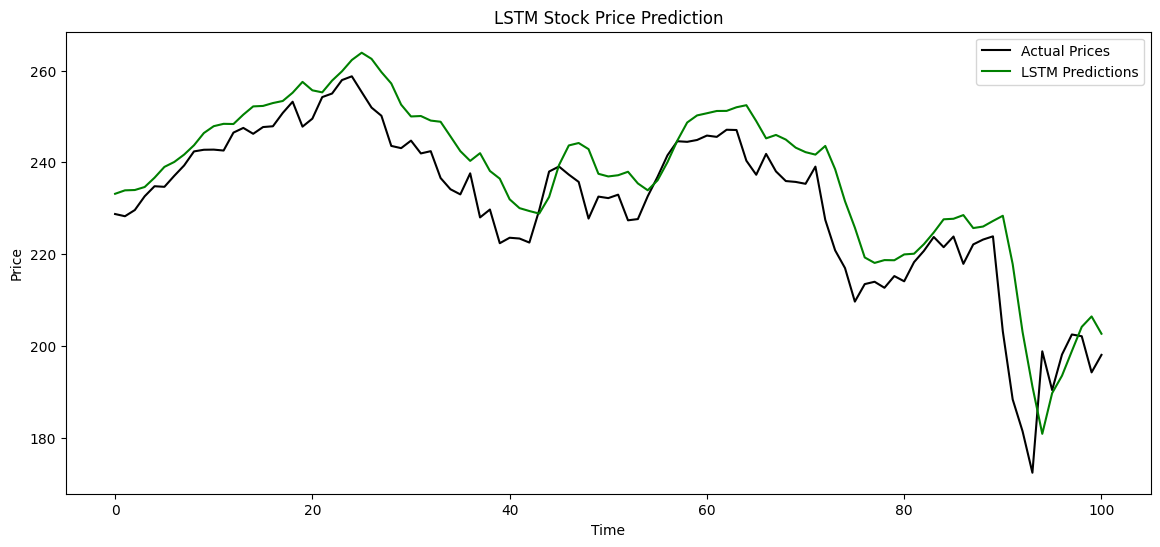

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load data & model
df = get_historical()
df = df[['Close']].dropna()

scaler = pickle.load(open("scaler.pkl", "rb"))
scaled_data = scaler.transform(df)

model = load_model("general_lstm_model.h5")

# Prepare test data
train_len = int(len(scaled_data) * 0.8)
test_data = scaled_data[train_len - 60:]
X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict & inverse scale
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Actual values
actual = df.values[train_len:]

# Plot
plt.figure(figsize=(14,6))
plt.plot(actual, label='Actual Prices', color='black')
plt.plot(predictions, label='LSTM Predictions', color='green')
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


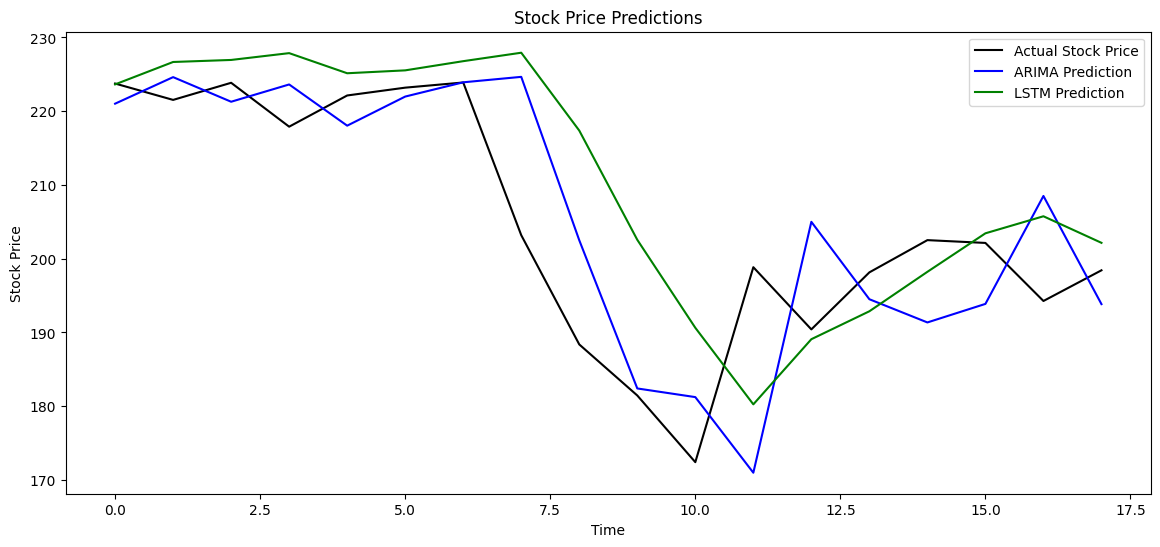

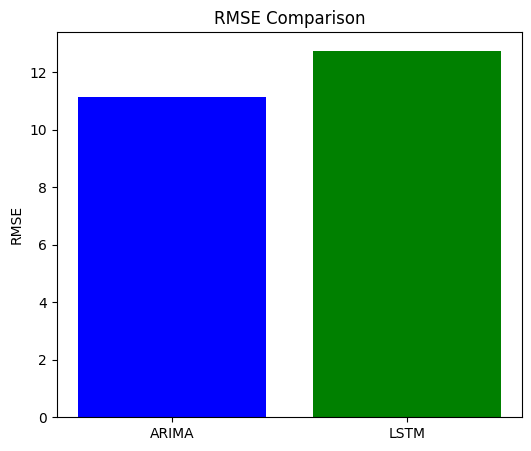

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import load_model
import yfinance as yf
import numpy as np
import pandas as pd
import pickle
import math

# Get data and run both models
df = get_historical("AAPL", period="90d")

arima_pred, arima_rmse = ARIMA_ALGO(df)
lstm_pred, lstm_rmse = LSTM_ALGO(df)
actual = df['Close'].values[int(0.8 * len(df)):]  # Last 20% as test set

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual Stock Price', color='black')
plt.plot(arima_pred, label='ARIMA Prediction', color='blue')
plt.plot([p[0] if isinstance(p, np.ndarray) else p for p in lstm_pred], label='LSTM Prediction', color='green')
plt.title('Stock Price Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# RMSE comparison bar chart
plt.figure(figsize=(6, 5))
plt.bar(['ARIMA', 'LSTM'], [arima_rmse, lstm_rmse], color=['blue', 'green'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()


[*********************100%***********************]  1 of 1 completed


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
Error fetching news: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}

📌 Stock Symbol: AAPL
📈 Actual Stock Price: 198.57000732421875
📊 ARIMA Prediction (Raw): 193.80158036910495
🤖 LSTM Prediction (Raw): 202.15460205078125
📰 Sentiment Index: 0
📌 Adjusted ARIMA Prediction: 193.80158036910495
📌 Adjusted LSTM Prediction: 202.15460205078125
➡️ Neutral Sentiment: No Strong Movement Expected


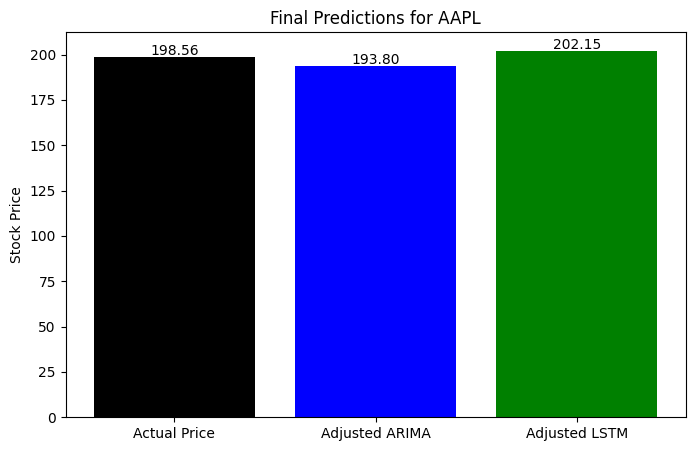

In [ ]:
stock_symbol = "AAPL"
news_api_key = "your_news_api_key_here"

# Run final prediction
final_arima_pred, final_lstm_pred = predict_stock(stock_symbol, news_api_key)

# Get actual price again for plotting
actual_data = yf.Ticker(stock_symbol).history(period="5d")
actual_price = actual_data["Close"].iloc[-1]

# Plot final predictions
labels = ['Actual Price', 'Adjusted ARIMA', 'Adjusted LSTM']
values = [actual_price, final_arima_pred, final_lstm_pred]
colors = ['black', 'blue', 'green']

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=colors)
plt.title(f'Final Predictions for {stock_symbol}')
plt.ylabel('Stock Price')
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.2f}", ha='center')
plt.show()
